In [243]:
from torchvision.datasets import CocoCaptions, CocoDetection, ImageFolder
from torchvision import transforms
from pycocotools.coco import COCO
import torchvision.models as models
import torch
import os
import json
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
pylab.rcParams['figure.figsize'] = (8.0, 10.0)



The purpose of this notebook is to work out how we can use the MSCOCO dataset as input.
We begin by loading the annotation file for the dataset

In [14]:
dataDir='/home/mappelgren/Desktop/correcting-agent/data/image_data'
dataType='train2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=8.80s)
creating index...
index created!


Imagenet Labels

In [156]:
image_net_labels = json.load(open('/home/mappelgren/Desktop/correcting-agent/data/image_data/imagenet_class_index.json'))

In [15]:
categories = coco.loadCats(coco.getCatIds())
names=[cat['name'] for cat in categories]
print('coco categories: \n{}\n'.format(', '.join(names)))

coco categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush



In [41]:
catIds = coco.getCatIds(catNms=['dog']);
imgIds = coco.getImgIds(catIds=catIds );
#imgIds = coco.getImgIds(imgIds = )


In [71]:
img = coco.loadImgs(imgIds)[:64]
print(len(img))
imgs = [i['coco_url'] for i in img]
I = io.ImageCollection(imgs)
I.data

64


array([None], dtype=object)

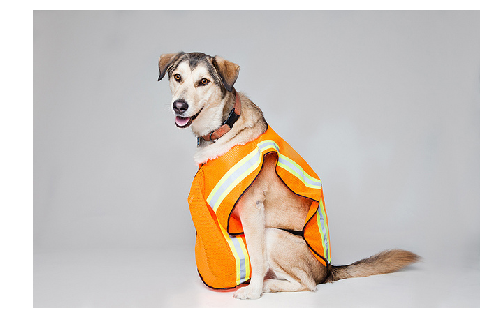

In [46]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

The following functions allow me to save a MSCOCO category to its own directory. This further allows us to lead the images using the ```torchvision.ImageFolder``` class.

In [79]:
def save_images(category, coco, modifier='train'):
    """Saves all images of a specified category locally"""
    image_store_root_dir = os.path.join("/home/mappelgren/Desktop/correcting-agent/data/image_data/coco_cat", modifier)
    image_store_dir = os.path.join(image_store_root_dir, category)
    os.makedirs(image_store_dir, exist_ok=True)
    
    image_urls = get_category_img_urls(category, coco)
    for url in image_urls:
        image_data = io.imread(url)
        image_name = url.split('/')[-1]
        image_store_file = os.path.join(image_store_dir, image_name)
        io.imsave(image_store_file, image_data)
    
        
    
def get_category_img_ids(category, coco):
    """Given a specific category returns the image ids of that category"""
    catIds = coco.getCatIds(catNms=[category]);
    imgIds = coco.getImgIds(catIds=catIds );
    img = coco.loadImgs(imgIds)
    return img

    
def get_category_img_urls(category, coco):
    """Given a specific category returns the urls for images associated to that category"""
    img = get_category_img_ids(category)
    imgs = [i['coco_url'] for i in img]
    return imgs

In [81]:
category_names = ['teddy bear', 'apple', 'tv', 'laptop', 'kite', 'knife', 'bottle', 'dog']
for category in category_names:
    save_images(category, coco)

/home/mappelgren/miniconda3/envs/phd/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/mappelgren/Desktop/correcting-agent/data/image_data/coco_cat/kite/COCO_train2014_000000377011.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


Here we load the coco dataset from the image folders I have just created. We perform the normalisation transform so that we comply with the normalisation done for the pretrained imagenet model we are using. Further the ```ToTensor``` transform is required since it seems pytorch will not automatically cast the images to tensors, so this avoids an error.

In [224]:
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

coco_categories = ImageFolder('/home/mappelgren/Desktop/correcting-agent/data/image_data/coco_cat', transform=train_transform)

In [253]:
coco_labels= {i:l for i, l in enumerate(coco_categories.classes)}

In [226]:
data_loader = torch.utils.data.DataLoader(coco_categories,
                                          batch_size=1,
                                          shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4])
['n07873807', 'pizza']


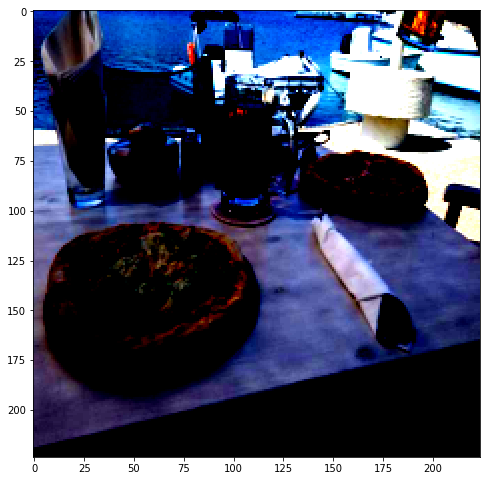

In [227]:
to_pil = ToPILImage()
for image, label in data_loader:
    #print(image.shape)
    #print(image.view(-1, 224, 224, 3).numpy().shape)
    
    #to_pil(image[0])
    #plt.imshow(image.view(-1, 224, 224, 3).numpy()[0])
    npimage = image[0].numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)), interpolation='nearest')
    v, l = vgg16(image).max(1)
    print(label)
    print(image_net_labels[str(int((l[0])))])
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])
torch.Size([1, 25088])


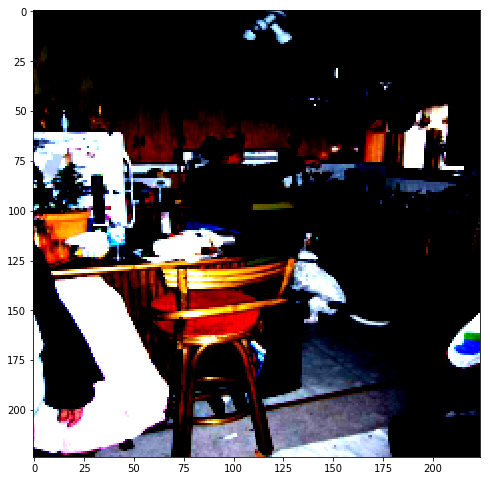

In [237]:
to_pil = ToPILImage()
for image, label in data_loader:
    #print(image.shape)
    #print(image.view(-1, 224, 224, 3).numpy().shape)
    
    #to_pil(image[0])
    #plt.imshow(image.view(-1, 224, 224, 3).numpy()[0])
    npimage = image[0].numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)), interpolation='nearest')
    out = vgg16.features(image)
    print(label)
    print(out.view(-1, 512*7*7).shape)
    break

In [248]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = vgg16.features
        for p in self.features.parameters():
            p.requires_grad = False
        self.lin1 = nn.Linear(512*7*7, 200)
        self.lin2 = nn.Linear(200, 100)
        self.lin3 = nn.Linear(100, 8)
        
    def forward(self, x):
        x = self.features(x).view(-1, 512*7*7)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
        
net = Net()        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([5])
torch.Size([1, 8])


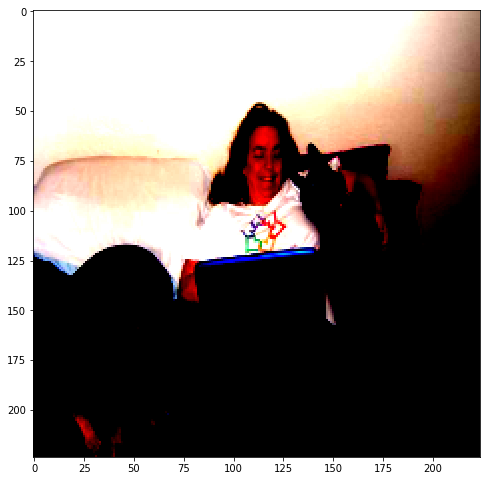

In [249]:
to_pil = ToPILImage()
for image, label in data_loader:
    #print(image.shape)
    #print(image.view(-1, 224, 224, 3).numpy().shape)
    
    #to_pil(image[0])
    #plt.imshow(image.view(-1, 224, 224, 3).numpy()[0])
    npimage = image[0].numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)), interpolation='nearest')
    out = net(image)
    print(label)
    print(out.shape)
    break

In [250]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [247]:
net.features.parameters()

<generator object Module.parameters at 0x7fa113bdfed0>

In [251]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.518
[1, 22000] loss: 14.344
[2,  2000] loss: 1.366
[2, 22000] loss: 14.712
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


apple: -0.6056180000305176
bottle: 0.6700868606567383
dog: 0.34001126885414124
kite: -0.4748117923736572
knife: -0.001637626439332962
laptop: -0.35713616013526917
teddy bear: 0.6843443512916565
tv: 0.1914934515953064
knife
teddy bear


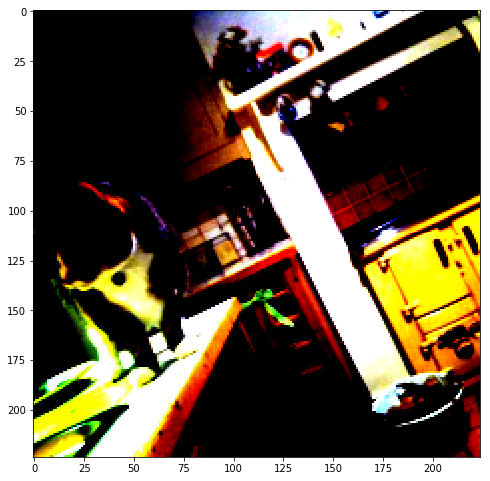

In [291]:
to_pil = ToPILImage()
for image, label in data_loader:
    #print(image.shape)
    #print(image.view(-1, 224, 224, 3).numpy().shape)
    
    #to_pil(image[0])
    #plt.imshow(image.view(-1, 224, 224, 3).numpy()[0])
    npimage = image[0].numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)), interpolation='nearest')
    
    out = net(image)
    v, l = net(image).max(1)

    print('\n'.join(['{}: {}'.format(coco_labels[i], o) for i, o in enumerate(out[0])]))    
    print(coco_labels[int(label[0])])
    
    print(coco_labels[int(l[0])])
    
    break